In [1]:
import ipywidgets as widgets
%matplotlib inline
import numpy as np
import csv
import CoordinateConversion as CC
import matplotlib.pyplot as plt
import pandas as pd
import math
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO
import vaex as vx
import random
import galpy.util.bovy_coords as gub
import astropy.io.fits as fits
from matplotlib import cm
import healpy as hp
import scipy.ndimage.filters  as snf
import emcee
import VRR_common as VC
import sys
sys.path.append('/Users/htian/Documents/GitHub/astroth/')
import ploth as pth
import scipy.stats as stats
import corner
# disk from carlin d/0.7

In [2]:
def MC_error(x,err):
    return np.random.normal(loc=x,scale=err)
   
def straightline(x,a,b):
    '''
    Straightline function
    '''
    return a + b*x

#Calculate velocity distribution at each bin, using Bayesian model
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
#hierachical Beyasian model

def gauss_model(y):
    # sampling
    n = len(y)
    y_bar = np.mean(y)
    s2 = np.var(y)
    
    #step 1: draw sigma2 from posterior density of 
    #        sigma2 given v, p(sigma2|y)
    N = 5000
    sigma2 = randDraw_SInvChi2(n-1,s2, N)
    #step 2 : draw mu from p(mu|sigma2,y)
    mu = np.random.normal(loc=y_bar, \
            scale=np.sqrt(sigma2/n))
    popt = np.array([n,np.mean(mu),np.mean(np.sqrt(sigma2))])
    pcov = np.array([[1.0,0.0,0.0],[0.0,np.var(mu),0.0],\
                     [0.0,0.0,np.var(np.sqrt(sigma2))]])
    return popt, pcov

def lnprob_gauss(x,y):
    mu1 = x[0]
    sig1 = x[1]
    if np.isinf(mu1) or np.isinf(sig1) or sig1<0 or\
               np.abs(mu1)>100 :
        return -1e50
    g = stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    return np.sum(np.log(g[ind_g]))

def gauss_mcmcmodel(y):
    # MCMC sampling
    #n = len(y)
    
    #start to configure emcee
    nwalkers = 20
    ndim = 2
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*50-25
    p0[:,1] = np.random.rand(nwalkers)*40+20
      
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, lnprob_gauss, args=[y])
    
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    sampler.run_mcmc(pos, 10000)
    
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov

def lnprob_gauss2(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    mu1 = x[1]
    sig1 = x[2]
    mu2 = x[3]
    sig2 = x[4]
    if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or\
                f1<0 or f1>1 or sig1<0 or sig2<0 or\
                sig1>200 or sig2>200 or\
                mu1>100 or mu1<-50 or mu2>300 or mu2<100:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])

def gauss2_model(y,p0,N, func, nwalkers):
    # MCMC sampling
    ndim = p0.shape[1]
    print(ndim)
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, func, args=[y])
    N_burn_in = 2000
    
    pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
    sampler.reset()
    
    sampler.run_mcmc(pos, N)
    
    samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)   # CHANGED HERE!!!!!!!!!!
#     popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov, samples

import time

In [3]:
def Gaussian2(x,a1,m1,s1,a2,m2,s2):
    return a1*np.exp(-((x-m1)/s1)**2)+a2*np.exp(-((x-m2)/s2)**2)
def Gaussian(x,a,m,s):
    return a*np.exp(-((x-m)/s)**2)

def kernalfunc(xc,yc,xarr,yarr,disp_x,disp_y):
#     wv = np.sum(tnp.exp(-(xarr-xc)**2/disp_x-(yarr-yc)**2/disp_y))
    wv = np.sum(\
        (2-(xarr-xc)**2/(disp_x**2)-(yarr-yc)**2/(disp_y**2)) * \
         np.exp(-0.5*(xarr-xc)**2/(disp_x**2)-0.5*(yarr-yc)**2/(disp_y**2)))
    return wv
    
#      current only for gaussian
def wavetrans(x,y,min_x,max_x,min_y,max_y,nx,ny,disp_x,disp_y):
    N = len(x)
    wght = np.zeros(N)
    bins_x = np.linspace(min_x,max_x,nx+1)
    bins_y = np.linspace(min_y,max_y,ny+1)
    stp_x = (max_x-min_x)/nx
    stp_y = (max_y-min_y)/ny
    for i in range(0,N):
        wght[i] = kernalfunc(x[i],y[i],x,y,disp_x*stp_x,disp_y*stp_y)
    wvnw,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y),weights=wght)
    wvn,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
#     print("___",len(bins_x[:-1]),np.max(wght))
    return wvnw,wvn,bins_x[:-1]+stp_x*0.5,bins_y[:-1]+stp_y*0.5

def lnprob_gauss3(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    f2 = x[1]
    mu1 = x[2]
    sig1 = x[3]
    mu2 = x[4]
    sig2 = x[5]
    mu3 = x[6]
    sig3 = x[7]
    if np.isinf(f1) or np.isinf(f2) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or np.isinf(mu3) or np.isinf(sig3) or\
                f1<0 or f1>1 or f2<0. or f2>1 or (f1+f2)<0 or (f1+f2)>1 or\
                sig1<0 or sig2<0 or sig3<0 or\
                sig1>200 or sig2>200 or sig3>400 or\
                mu1>100 or mu1<-100 or mu3>100 or mu3<-200 or mu2>300 or mu2<50:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = f2*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g3 = (1-f1-f2)*stats.norm.pdf(y,mu3,sig3)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2+g3
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])

def draw_VT(vt,Mpopt3,filename,label=""):
    vgrid = np.arange(-400,400,10.)
    vcenter = (vgrid[:-1]+vgrid[1:])/2.
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_axes([0.13,0.4,0.85,0.55])
    h,xedge = np.histogram(vt,vgrid)
    ax.errorbar(vcenter, h, yerr=np.sqrt(h),fmt='ko')
    g1 = Mpopt3[0]*stats.norm.pdf(vcenter,Mpopt3[2],Mpopt3[3])
    g2 = Mpopt3[1]*stats.norm.pdf(vcenter,Mpopt3[4],Mpopt3[5])
    g3 = (1-Mpopt3[0]-Mpopt3[1])*stats.norm.pdf(vcenter,Mpopt3[6],Mpopt3[7])
    g = g1+g2+g3
    ax.plot(vcenter, g/np.sum(g)*np.sum(h),'k-',linewidth=3)
    ax.plot(vcenter, g1/np.sum(g)*np.sum(h),'r--')
    ax.plot(vcenter, g2/np.sum(g)*np.sum(h),'b--')
    ax.plot(vcenter, g3/np.sum(g)*np.sum(h),'g--')
    max_y = np.max(g/np.sum(g)*np.sum(h))*1.3
    ax.text(-390,max_y*0.9,label,fontsize=20)
    ax.set_ylim([0,max_y])
    ax.plot([0,0],[0,max_y],'c--',linewidth=2)
    ax.set_xlim([-400,400])
    ax.set_xticks(np.arange(-400,400,50))
    ax.set_xticklabels([])
    ax.set_ylabel(r'Count',fontsize=20)

    ax = fig.add_axes([0.13,0.13,0.85,0.25])
    ax.errorbar(vcenter, h-g/np.sum(g)*np.sum(h),yerr=np.sqrt(h),fmt='ko')
    ax.plot([-400,400],[0,0],'r-.')
    ax.set_xlim([-400,400])
    ax.set_xticks(np.arange(-400,400,50))
    ax.set_xticklabels(['-400','','-300','','-200','','-100','','0','','100','','200','','300','','400'])
    ax.set_ylim([-48,48])
    ax.set_ylabel('Data-Model',fontsize=20)
    ax.set_xlabel(r'$V_T$ (km s$^{-1}$)',fontsize=20)
#     fig.show()

    fig.savefig(filename,bbox_inches='tight')

In [4]:
dpath = "/Users/htian/Documents/work/data/rothalo/"
# gpath = "/Users/htian/Documents/work/data/Gaia/"
ppath = "/Users/htian/Documents/work/plots/rothalo/"
# fn = "DR3_Kgiants_xxxdist_DR5_Gaia"
fn = "dr5GaiaDR2_v1_all_photos_EWs_dist_halo_feh_le_m1_TRUEKGIANT_NODUPLICATED"
d_fmt = ".fits"
fn_tag="Outerhalo_"

In [5]:
# in LSR frame
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
X_sun = 8.3
V_LSR = 232#232#218#232
# fn_tag = "XXX_"#"vlsr218_"#"dGaia_" #"vlsr218_"  240 Reid et al 2014 

In [6]:
# _1 是dr5的数据，_2是dr3的
DtG = fits.open(dpath+fn+d_fmt)
data_all = DtG[1].data
ra_all = data_all["ra_epoch2000_1"]
dec_all = data_all["dec_epoch2000_1"]
# ra_all = data_all["ra_epoch2000"]
# dec_all = data_all["dec_epoch2000"]
# r_xxx = data_all[""]
r_parax = data_all["r_est_1"]
r_dist = data_all["DistK50_RJCE_1"]
r_diste = 0.5/0.7*(data_all["DistK85_RJCE_1"] - data_all["DistK15_RJCE_1"])
# dist_xxx_all = data_all["d_xxx"]
# diste_xxx_all = data_all["d_err_xxx"]
rv_all = data_all["rv_1"]+5.38
rve_all = data_all["rv_err_1"]
rvg_all = data_all["radial_velocity_1"]
pmra_all = data_all["pmra_1"]
pmrae_all = data_all["pmra_error_1"]
pmdec_all = data_all["pmdec_1"]
pmdece_all = data_all["pmdec_error_1"]
feh_all = data_all["feh_1"]
fehe_all = data_all["feh_err_1"]
dist_all = r_dist*1.0
diste_all = r_diste*1.0

[0, 20, 0, 20]

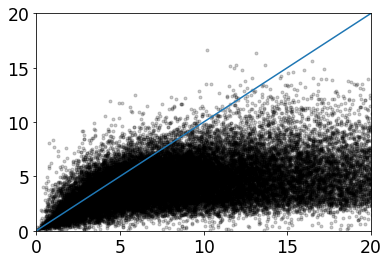

In [7]:
plt.plot(r_dist/1000,r_parax/1000,'k.',alpha=0.2)
plt.plot([0,100],[0,100])
plt.axis([0,20,0,20])

In [8]:
ind = (pmra_all == pmra_all) & (pmdec_all == pmdec_all) & (dist_all==dist_all)
ra_all0 = ra_all[ind]
dec_all0 = dec_all[ind]
dist_all0 =dist_all[ind]/1000
diste_all0 =diste_all[ind]/1000
rv_all0 =rv_all[ind]
rve_all0 =rve_all[ind]
rvg_all0 =rvg_all[ind]
pmra_all0 =pmra_all[ind]
pmrae_all0 =pmrae_all[ind]
pmdec_all0 =pmdec_all[ind]
pmdece_all0 =pmdece_all[ind]
feh_all0 =feh_all[ind]
fehe_all0 =fehe_all[ind]

# ind0 = (dist_all0>=0) & (dist_all0<4) & (feh_all0<-1) & (diste_all0/dist_all0<0.2)
ind0 = (feh_all0<-1) & (diste_all0/dist_all0<0.2)
print(len(dist_all0[ind0]),'************')
print(np.max(dist_all0))


ra = ra_all0[ind0]
dec = dec_all0[ind0]
dist =dist_all0[ind0]
diste =diste_all0[ind0]
rv =rv_all0[ind0]
rve =rve_all0[ind0]
rvg =rvg_all0[ind0]
pmra =pmra_all0[ind0]
pmrae =pmrae_all0[ind0]
pmdec =pmdec_all0[ind0]
pmdece =pmdece_all0[ind0]
feh =feh_all0[ind0]
fehe =fehe_all0[ind0]

llbb = gub.radec_to_lb(ra,dec,degree=True)
# centered at LSR, with galactic center at (X_sun,0,0)kpc
xyz = gub.lbd_to_XYZ(llbb[:,0],llbb[:,1],dist,degree=True)  
pmllbb = gub.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
vxvyvz = gub.vrpmllpmbb_to_vxvyvz(rv,pmllbb[:,0],pmllbb[:,1],llbb[:,0],llbb[:,1],\
                                  dist,degree=True)
# here the sun's uvw in GC frame, XYZ in gc frame, UVW in LSR frame
vrvtvz = gub.vxvyvz_to_galcencyl(vxvyvz[:,0],vxvyvz[:,1],vxvyvz[:,2],\
                                 X_sun-xyz[:,0],xyz[:,1],xyz[:,2],[U_sun*(-1),V_LSR+V_sun,W_sun])  
xyz_gc = xyz*1.0
xyz_gc[:,0] = 8.3-xyz[:,0]

# cvmt = np.array([[],
#                 [],
#                 []])

47281 ************
205.288300929


47281
-1.001
-21317.4964155 9726.95700908


Text(0,0.5,'$count(*)$')

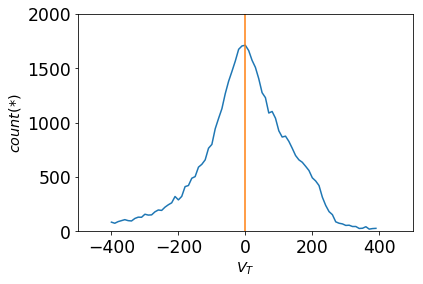

In [9]:
print(len(vrvtvz[:,0]))
print(np.max(feh_all))
print(np.min(vrvtvz[:,0]),np.max(vrvtvz[:,0]))
bins_vt = np.linspace(-400,400,81)
hy,hx = np.histogram(vrvtvz[:,1],bins = bins_vt)
plt.plot(hx[:-1],hy)
plt.plot([0,0],[0,2000])
plt.axis([-500,500,0,2000])
plt.xlabel('$V_T$')
plt.ylabel("$count(*)$")

In [10]:
nwalkers = 50
ndim = 8
p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*0.2+0.5
p0[:,1] = np.random.rand(nwalkers)*0.2
p0[:,2] = np.random.rand(nwalkers)*100-50
p0[:,3] = np.random.rand(nwalkers)*40+60
p0[:,4] = np.random.rand(nwalkers)*60+140
p0[:,5] = np.random.rand(nwalkers)*50+20
p0[:,6] = np.random.rand(nwalkers)*60-80
p0[:,7] = np.random.rand(nwalkers)*200
start = time.time()
# Mpopt3,Mpcov3, samples3 = gauss2_model(vrvtvz[:,1], p0, 5000, lnprob_gauss3, nwalkers)
# # draw_VT(vt,Mpopt3,'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_vt_distribution.eps')

In [11]:
# draw_VT(vrvtvz[:,1],Mpopt3,'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_vt_distribution.eps')
# print(Mpopt3)

/Users/htian/Documents/work/plots/rothalo/Outerhalo_xyz.eps


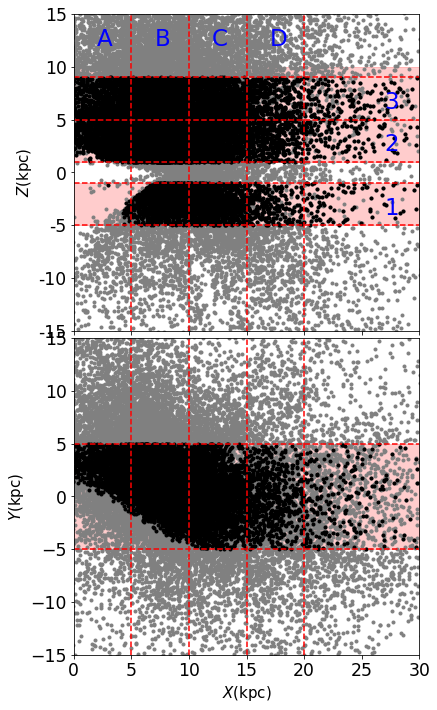

In [12]:
ind_y=(np.abs(xyz_gc[:,1])<5) & (np.abs(xyz_gc[:,2])>1) & (np.abs(xyz_gc[:,2])<5)
ind3 = (np.abs(xyz_gc[:,1])<5) & (np.abs(xyz_gc[:,2]-7)<2)
fig = plt.figure(figsize=(6,10))
ax1 = fig.add_axes([0.15,0.52,0.8,0.44])
ax2 = fig.add_axes([0.15,0.07,0.8,0.44])
ax1.fill_between([0,30],[5,5],[10,10],color='red',alpha=0.2)
ax1.fill_between([0,30],[5,5],[1,1],color='red',alpha=0.2)
ax1.fill_between([0,30],[-5,-5],[-1,-1],color='red',alpha=0.2)
ax1.scatter(xyz_gc[:,0],xyz_gc[:,2],marker='.',color="gray")
ax1.plot(xyz_gc[ind_y,0],xyz_gc[ind_y,2],'k.')
ax1.plot(xyz_gc[ind3,0],xyz_gc[ind3,2],'k.')
ax1.axis([0,30,-15,15])
ax1.plot([0,30],[9,9],'r--')
ax1.plot([0,30],[5,5],'r--')
ax1.plot([0,30],[-5,-5],'r--')
ax1.plot([0,30],[1,1],'r--')
ax1.plot([0,30],[-1,-1],'r--')
ax2.fill_between([0,30],[-5,-5],[5,5],color='red',alpha=0.2)
ax2.scatter(xyz_gc[:,0],xyz_gc[:,1],marker='.',color="gray")
ax2.plot(xyz_gc[ind_y,0],xyz_gc[ind_y,1],'k.')
ax2.axis([0,30,-15,15])
ax2.plot([0,30],[5,5],'r--')
ax2.plot([0,30],[-5,-5],'r--')

ax1.plot([5,5],[-15,15],'r--')
ax2.plot([5,5],[-15,15],'r--')
ax1.plot([10,10],[-15,15],'r--')
ax2.plot([10,10],[-15,15],'r--')
ax1.plot([15,15],[-15,15],'r--')
ax2.plot([15,15],[-15,15],'r--')
ax1.plot([20,20],[-15,15],'r--')
ax2.plot([20,20],[-15,15],'r--')

ax1.text(2,12,'A',fontsize=23,color='b')
ax1.text(7,12,'B',fontsize=23,color='b')
ax1.text(12,12,'C',fontsize=23,color='b')
ax1.text(17,12,'D',fontsize=23,color='b')
ax1.text(27,6,'3',fontsize=23,color='b')
ax1.text(27,2,'2',fontsize=23,color='b')
ax1.text(27,-4,'1',fontsize=23,color='b')
ax1.set_xticks(np.linspace(0,30,7))
ax1.set_xticklabels("")
ax1.set_yticks(np.linspace(-15,15,7))
ax1.set_yticklabels(["","-10","-5","0","5","10","15"])
ax1.set_xticks(np.linspace(0,30,7))
ax1.set_yticks(np.linspace(-15,15,7))
ax1.set_yticklabels(["-15","-10","-5","0","5","10","15"])
ax1.set_ylabel("$Z$(kpc)",fontsize=15)
ax2.set_ylabel("$Y$(kpc)",fontsize=15)
ax2.set_xlabel("$X$(kpc)",fontsize=15)
plt.savefig(ppath+fn_tag+"xyz.pdf")
print(ppath+fn_tag+"xyz.eps")

# plotvvv = pth.ploth3D(vrvtvz[:,0],vrvtvz[:,1],vrvtvz[:,2])
# plotvvv.ploth_2sub_scatter(xlabel=["$V_R$","$V_T$"],ylabel=["$V_Z$","$V_Z$"])



10624 47281
8


f_1=0.760\pm0.098,f_2=0.199\pm0.019,
v_1=27 \pm 8 km/s,\sigma_1=100 \pm 4 km/s
v_2=174 \pm 18 km/s,\sigma_2=47 \pm 16 km/s
v_3=-194 \pm 38 km/s,\sigma_3=304 \pm 33 km/s
------------------------------------------


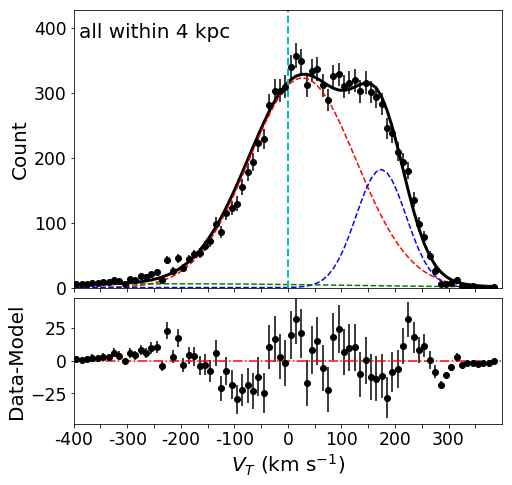

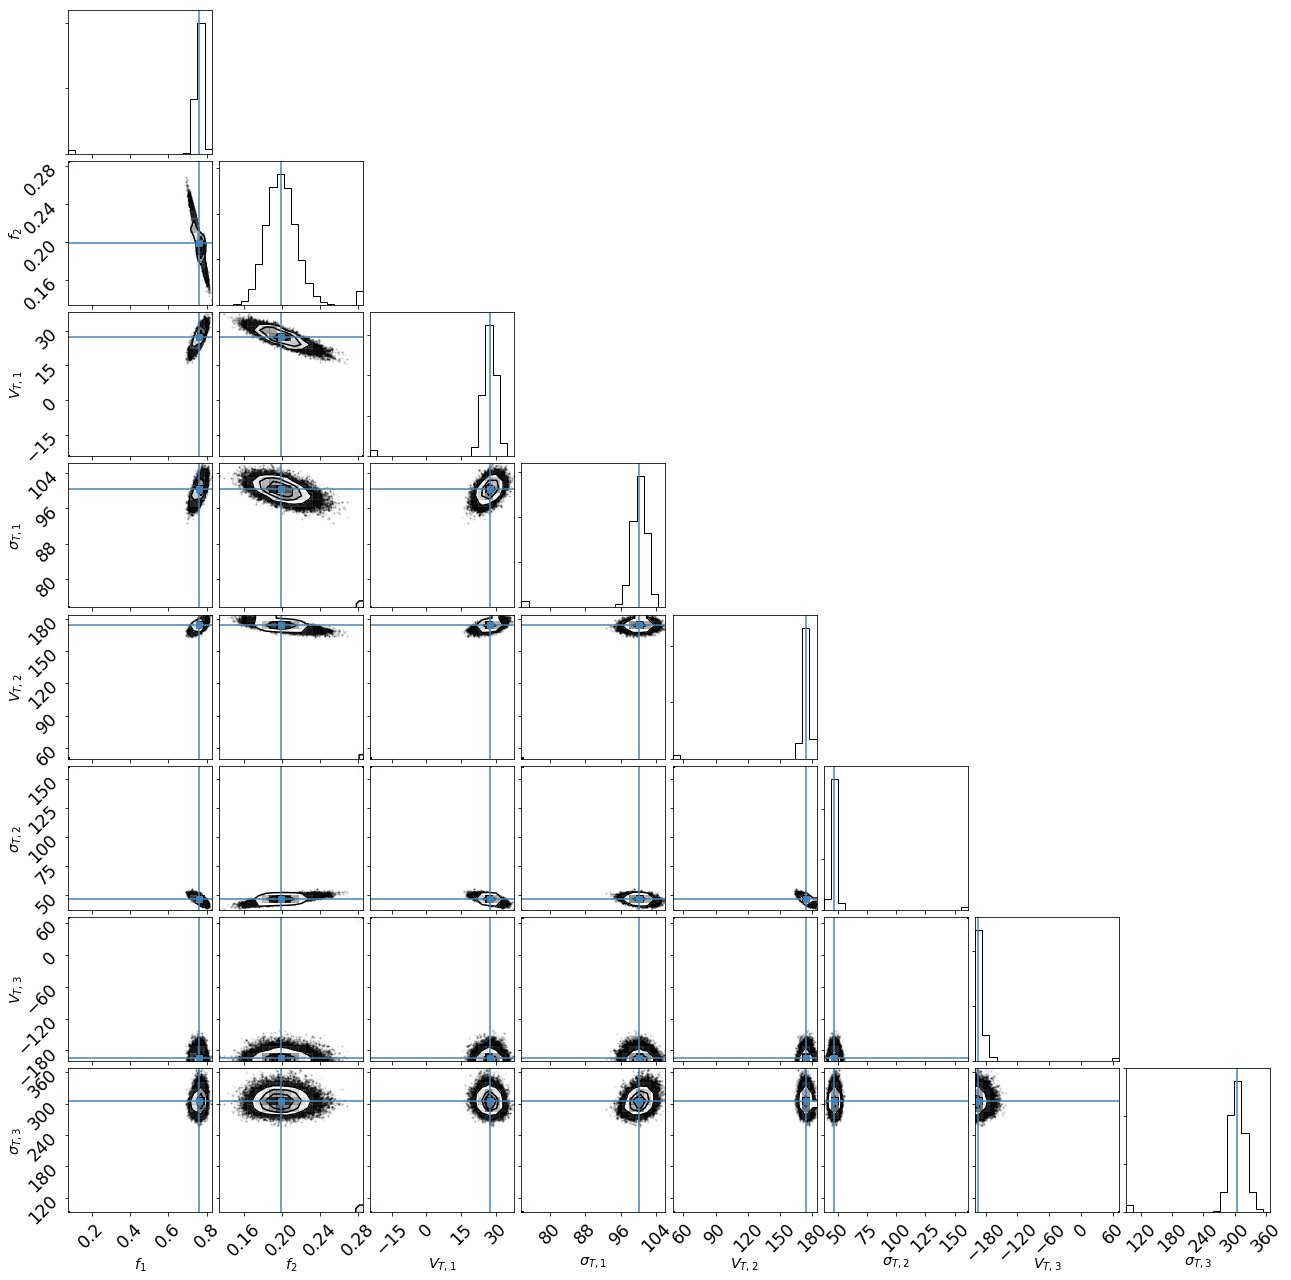

In [13]:
ind4 = dist<4
print(len(vrvtvz[ind4,1]),len(vrvtvz[:,1]))
Mpopt3,Mpcov3, samples3 = gauss2_model(vrvtvz[ind4,1], p0, 5000, lnprob_gauss3, nwalkers)
ss = np.sqrt(np.diag(Mpcov3))
draw_VT(vrvtvz[ind4,1],Mpopt3,"","all within 4 kpc")
fig = corner.corner(samples3,labels=["$f_1$","$f_2$","$V_{T,1}$","$\sigma_{T,1}$",\
                                     "$V_{T,2}$","$\sigma_{T,2}$",\
                                     "$V_{T,3}$","$\sigma_{T,3}$"],\
                    truths=Mpopt3,fontsize=15)
print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' %\
      {'f1':Mpopt3[0],'f1e':ss[0],'f2':Mpopt3[1],'f2e':ss[1]})
print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' %\
      {'v1':Mpopt3[2],'v1e':ss[2],'s1':Mpopt3[3],'s1e':ss[3]})
print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' %
      {'v2':Mpopt3[4],'v2e':ss[4],'s2':Mpopt3[5],'s2e':ss[5]})
print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' %\
      {'v3':Mpopt3[6],'v3e':ss[6],'s3':Mpopt3[7],'s3e':ss[7]})
print("------------------------------------------")



A1  34
A2  1792
8


f_1=0.214\pm0.252,f_2=0.708\pm0.293,
v_1=-13 \pm 52 km/s,\sigma_1=121 \pm 35 km/s
v_2=61 \pm 39 km/s,\sigma_2=101 \pm 16 km/s
v_3=-114 \pm 50 km/s,\sigma_3=170 \pm 48 km/s
------------------------------------------
A3  1167
8
f_1=0.819\pm0.095,f_2=0.061\pm0.098,
v_1=-18 \pm 12 km/s,\sigma_1=115 \pm 6 km/s
v_2=64 \pm 68 km/s,\sigma_2=82 \pm 40 km/s
v_3=-184 \pm 18 km/s,\sigma_3=384 \pm 16 km/s
------------------------------------------
B1  1994
8
f_1=0.861\pm0.041,f_2=0.099\pm0.037,
v_1=29 \pm 6 km/s,\sigma_1=98 \pm 5 km/s
v_2=177 \pm 7 km/s,\sigma_2=42 \pm 8 km/s
v_3=-166 \pm 30 km/s,\sigma_3=312 \pm 32 km/s
------------------------------------------
B2  9051
8
f_1=0.796\pm0.020,f_2=0.147\pm0.019,
v_1=23 \pm 3 km/s,\sigma_1=98 \pm 2 km/s
v_2=160 \pm 4 km/s,\sigma_2=45 \pm 3 km/s
v_3=-189 \pm 11 km/s,\sigma_3=275 \pm 11 km/s
------------------------------------------
B3  3183
8


f_1=0.655\pm0.090,f_2=0.203\pm0.094,
v_1=-22 \pm 11 km/s,\sigma_1=95 \pm 3 km/s
v_2=53 \pm 34 km/s,\sigma_2=69 \pm 19 km/s
v_3=-196 \pm 5 km/s,\sigma_3=306 \pm 14 km/s
------------------------------------------
C1  1563
8
f_1=0.811\pm0.024,f_2=0.119\pm0.021,
v_1=-2 \pm 5 km/s,\sigma_1=95 \pm 4 km/s
v_2=197 \pm 7 km/s,\sigma_2=41 \pm 5 km/s
v_3=-189 \pm 14 km/s,\sigma_3=391 \pm 10 km/s
------------------------------------------
C2  2422
8


f_1=0.907\pm0.108,f_2=0.026\pm0.110,
v_1=4 \pm 9 km/s,\sigma_1=99 \pm 3 km/s
v_2=93 \pm 61 km/s,\sigma_2=79 \pm 36 km/s
v_3=-191 \pm 11 km/s,\sigma_3=376 \pm 18 km/s
------------------------------------------
C3  1558
8


f_1=0.648\pm0.062,f_2=0.234\pm0.063,
v_1=-48 \pm 9 km/s,\sigma_1=98 \pm 4 km/s
v_2=53 \pm 7 km/s,\sigma_2=63 \pm 6 km/s
v_3=-196 \pm 6 km/s,\sigma_3=391 \pm 10 km/s
------------------------------------------
D1  261
D2  445
8
f_1=0.730\pm0.031,f_2=0.134\pm0.018,
v_1=-9 \pm 5 km/s,\sigma_1=82 \pm 6 km/s
v_2=206 \pm 3 km/s,\sigma_2=18 \pm 3 km/s
v_3=-182 \pm 21 km/s,\sigma_3=345 \pm 30 km/s
------------------------------------------
D3  400
8


f_1=0.667\pm0.074,f_2=0.030\pm0.063,
v_1=-15 \pm 11 km/s,\sigma_1=80 \pm 6 km/s
v_2=215 \pm 64 km/s,\sigma_2=20 \pm 37 km/s
v_3=-197 \pm 18 km/s,\sigma_3=161 \pm 75 km/s
------------------------------------------


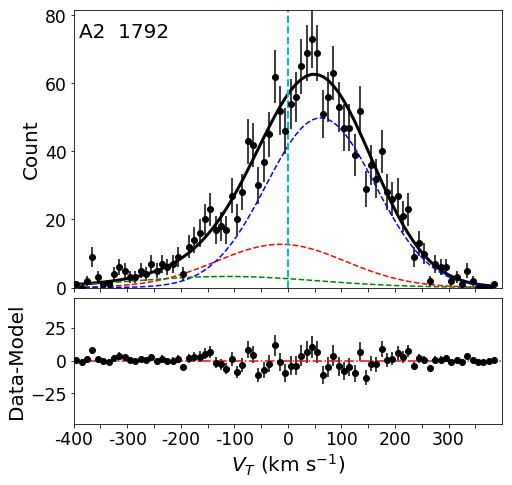

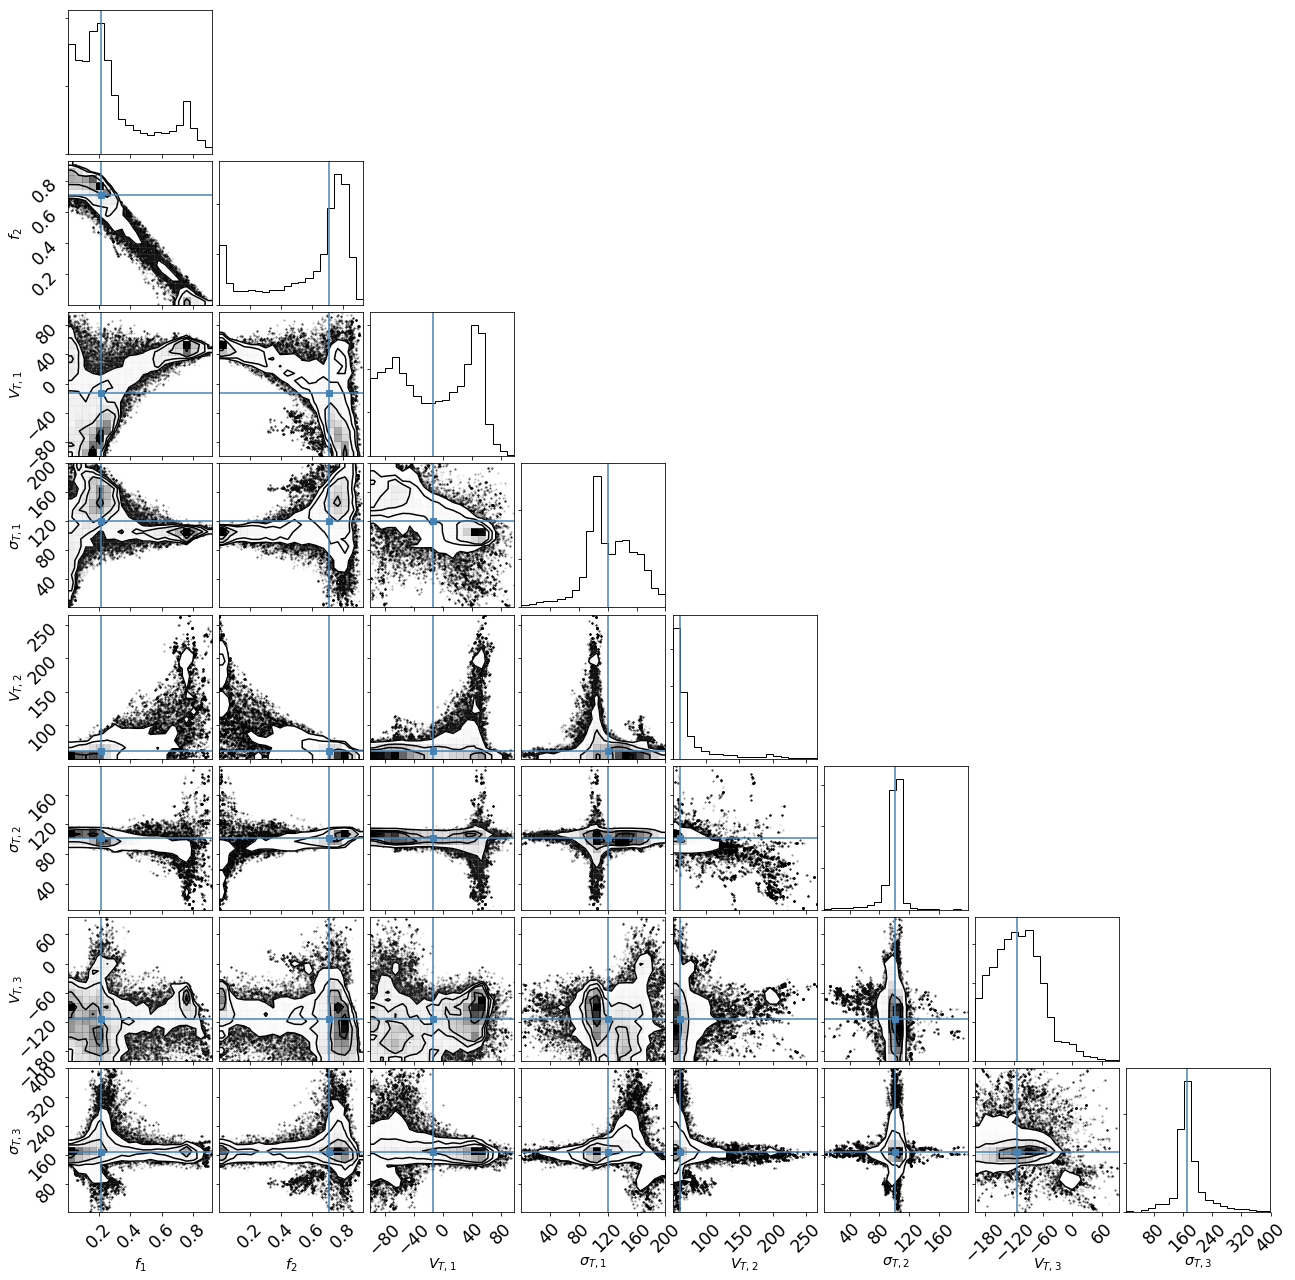

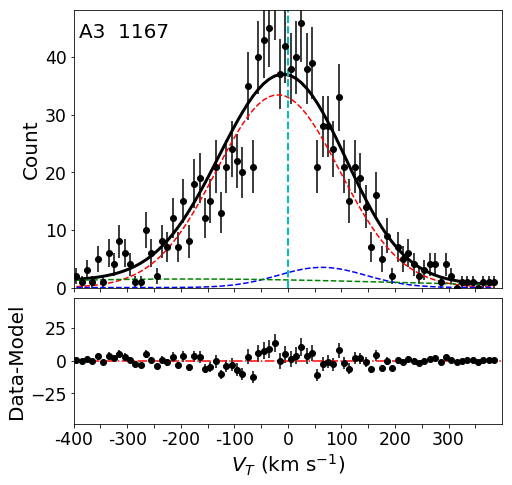

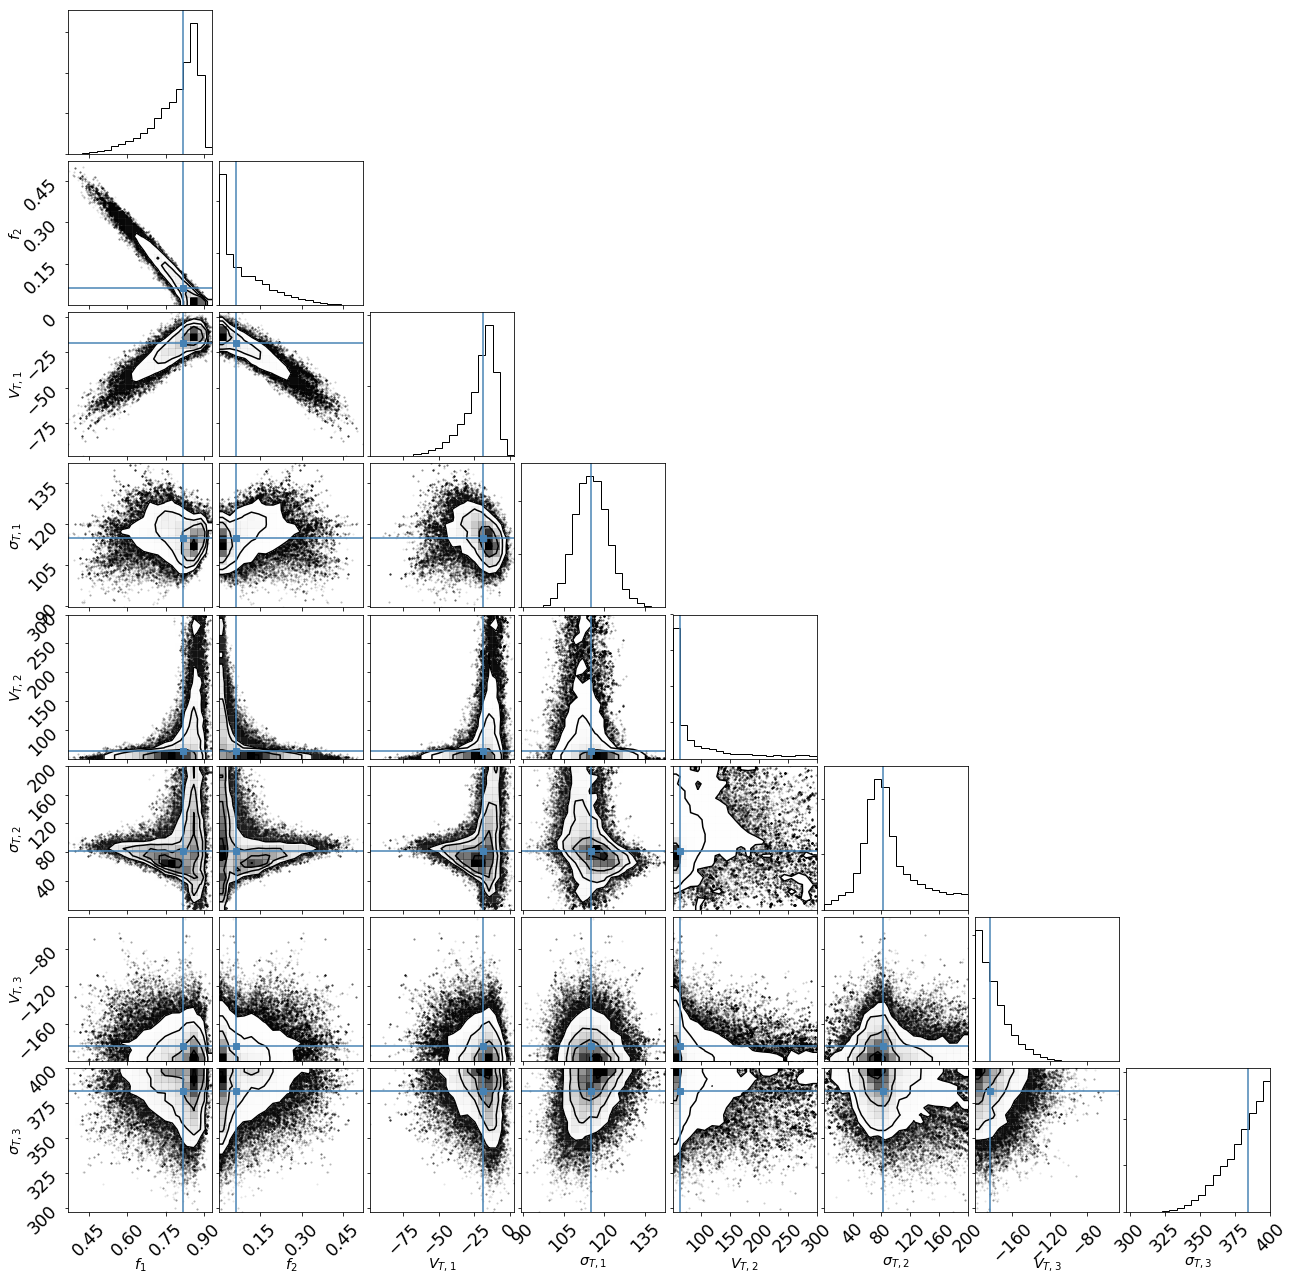

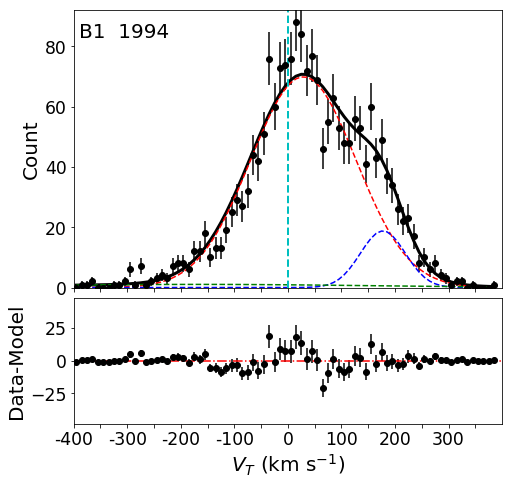

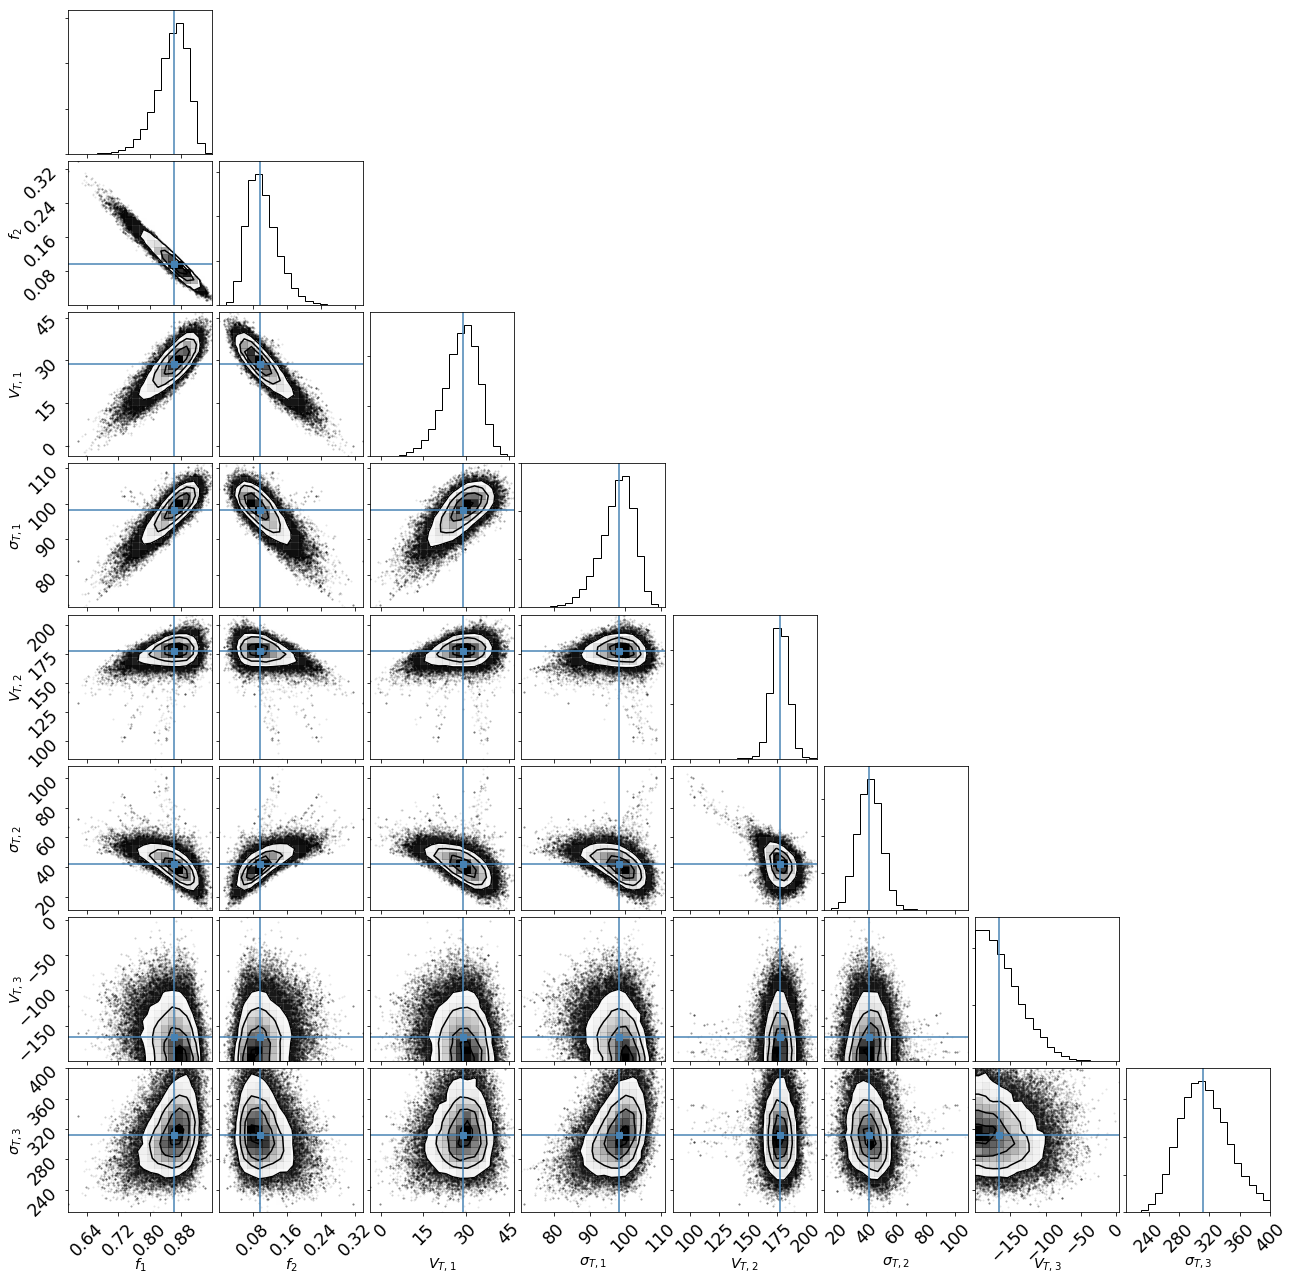

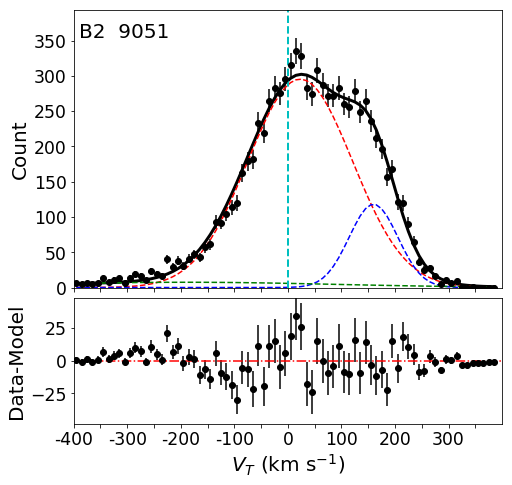

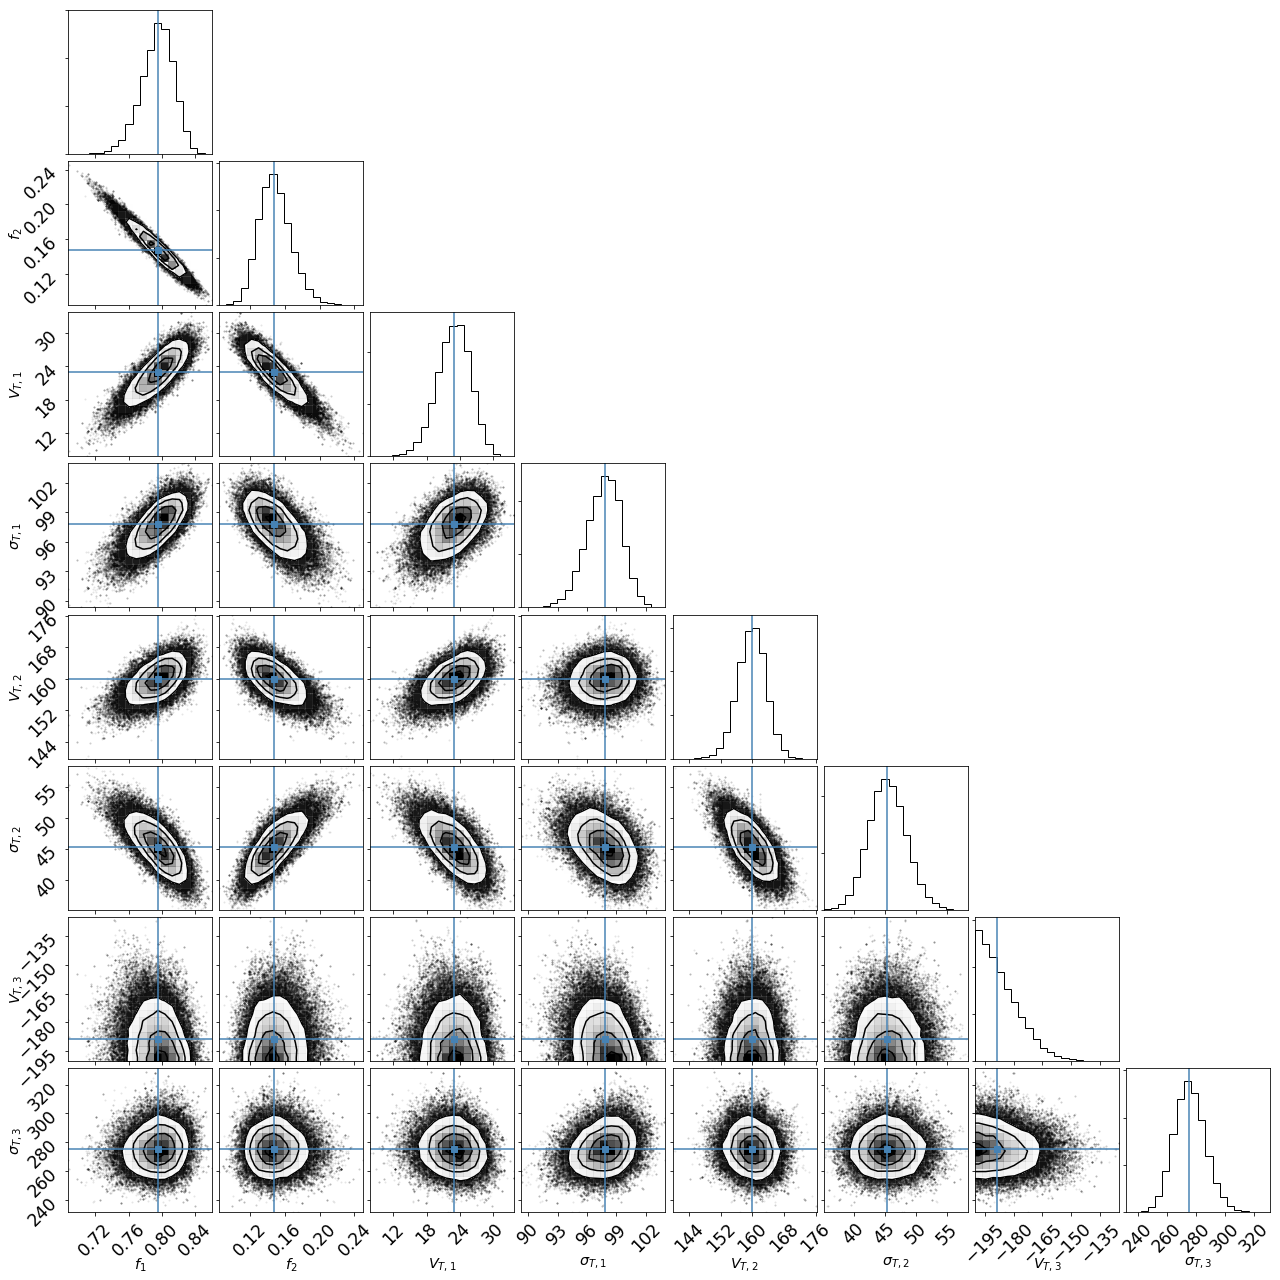

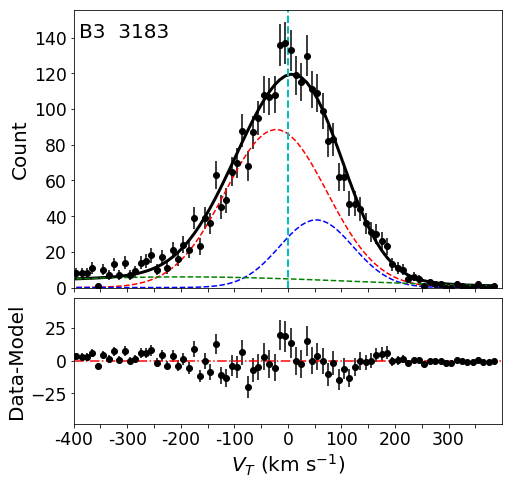

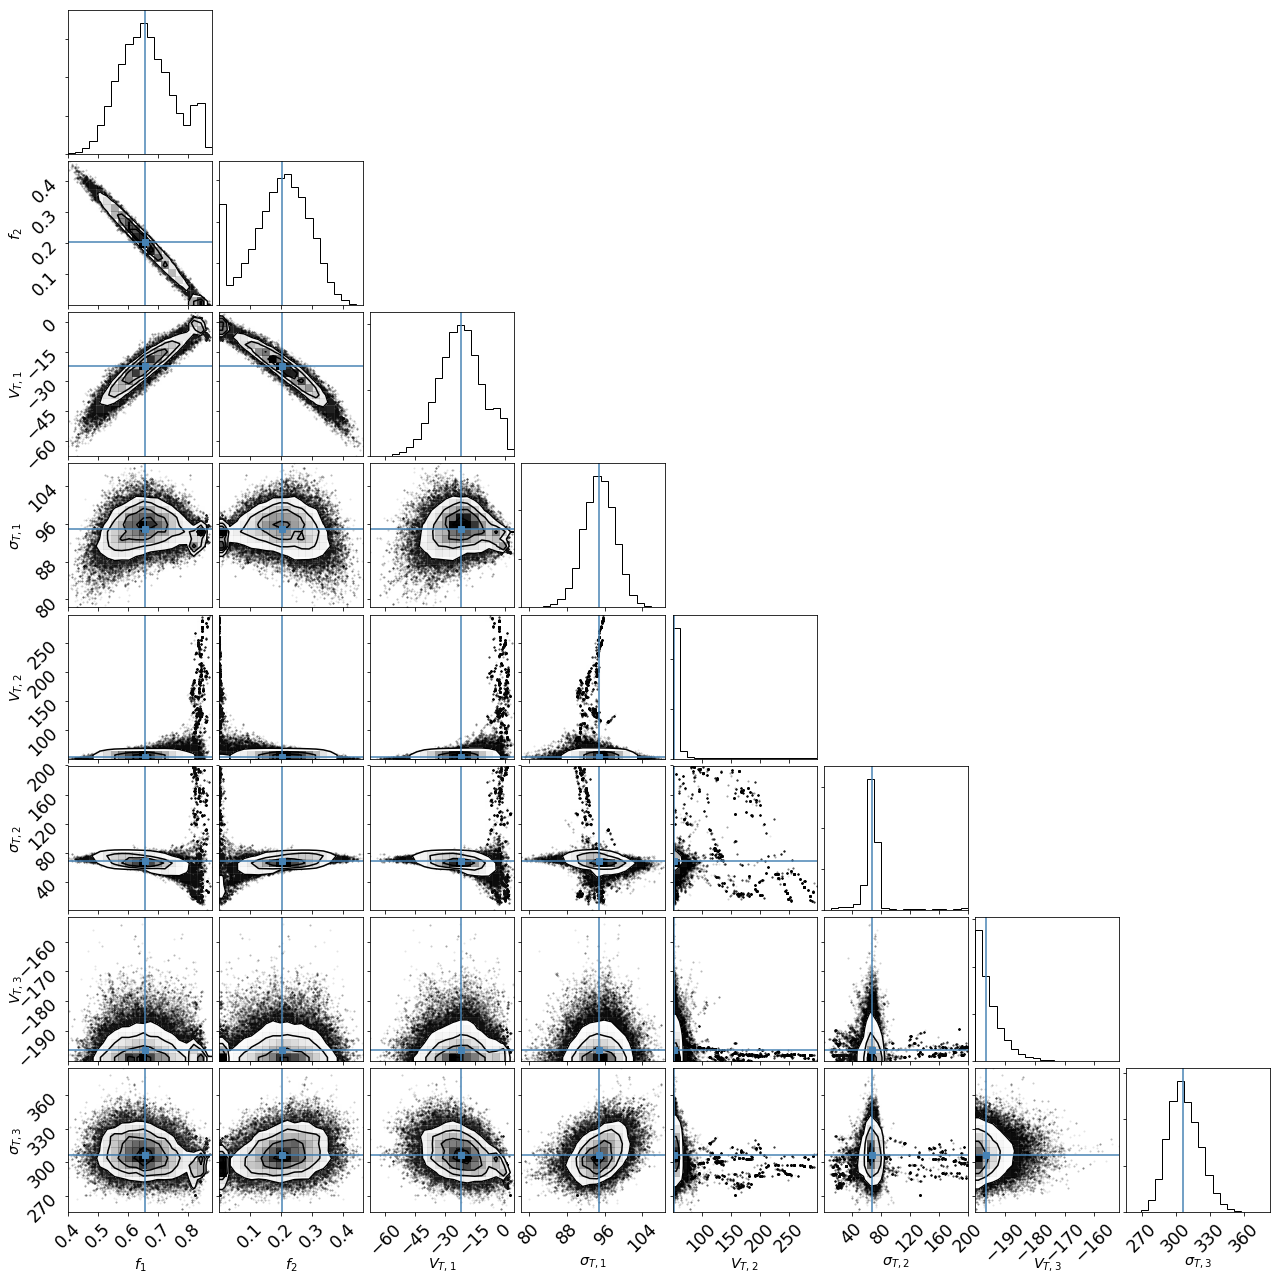

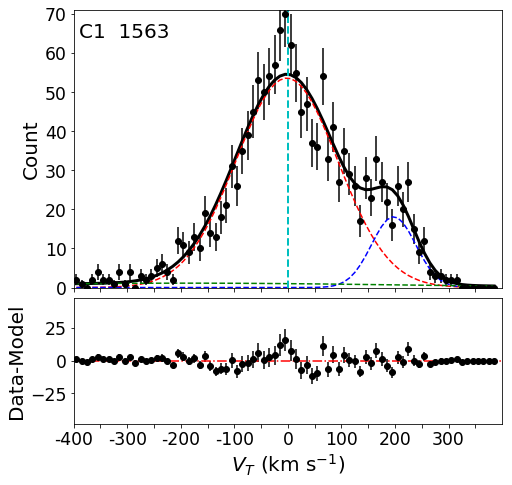

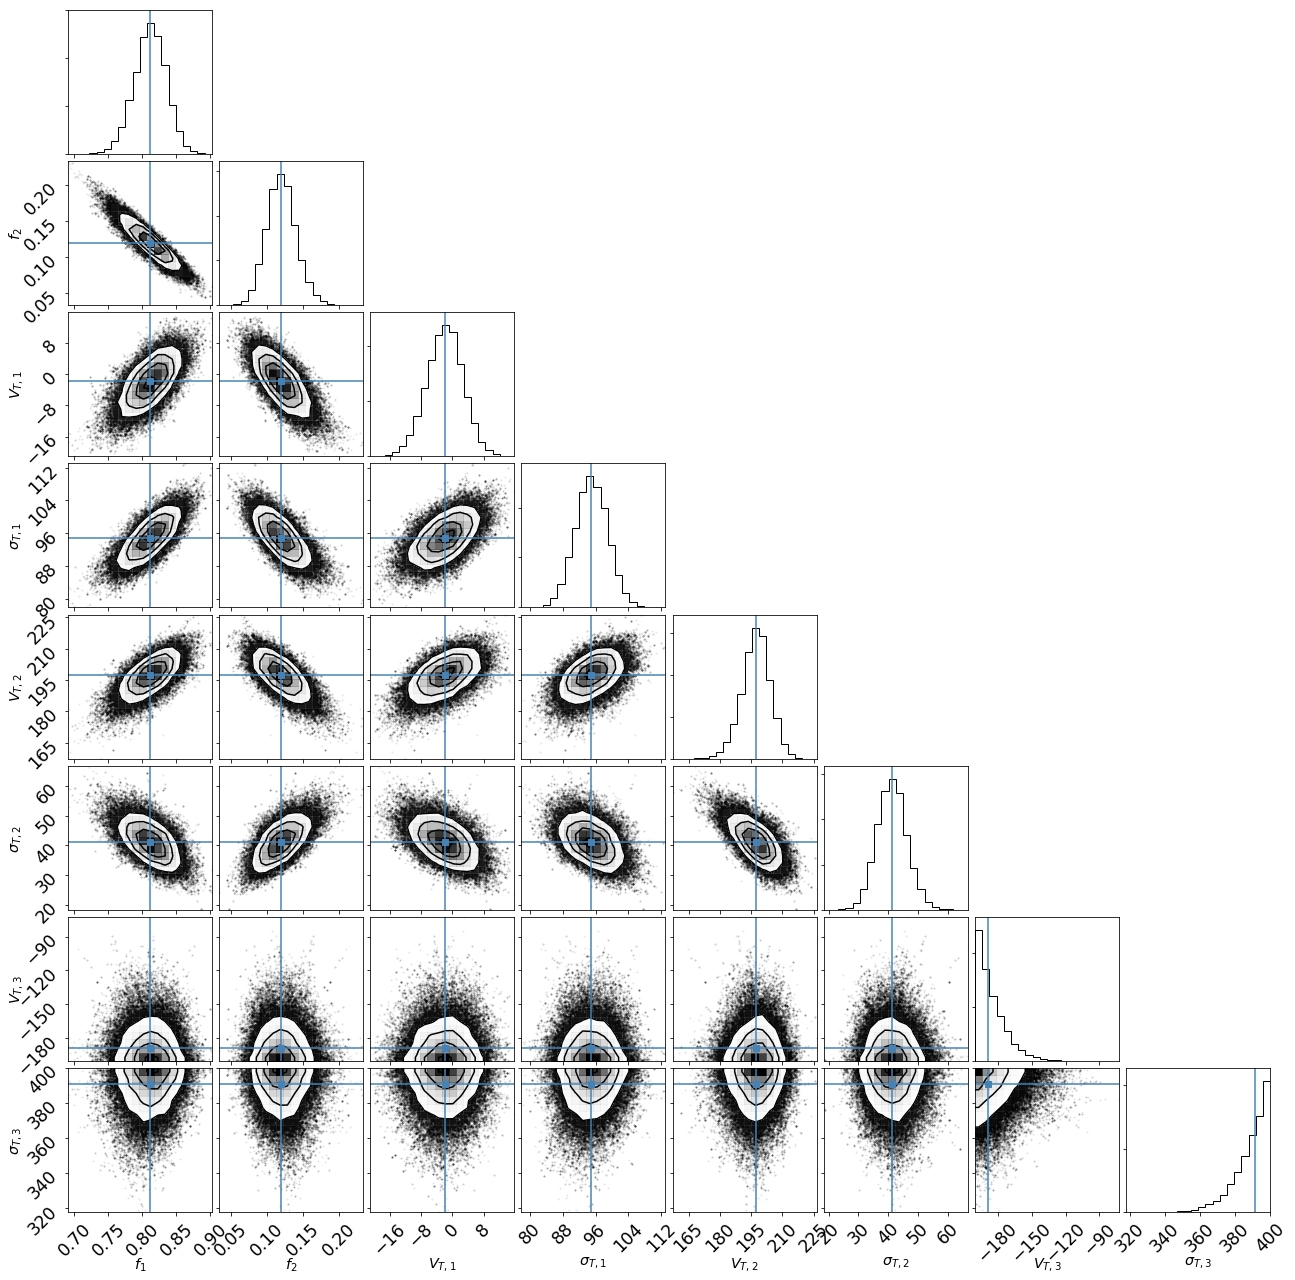

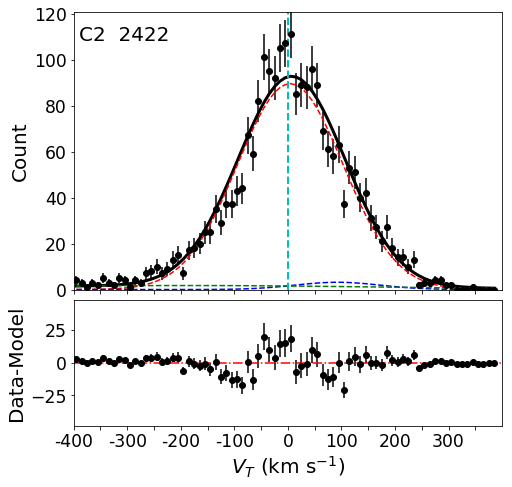

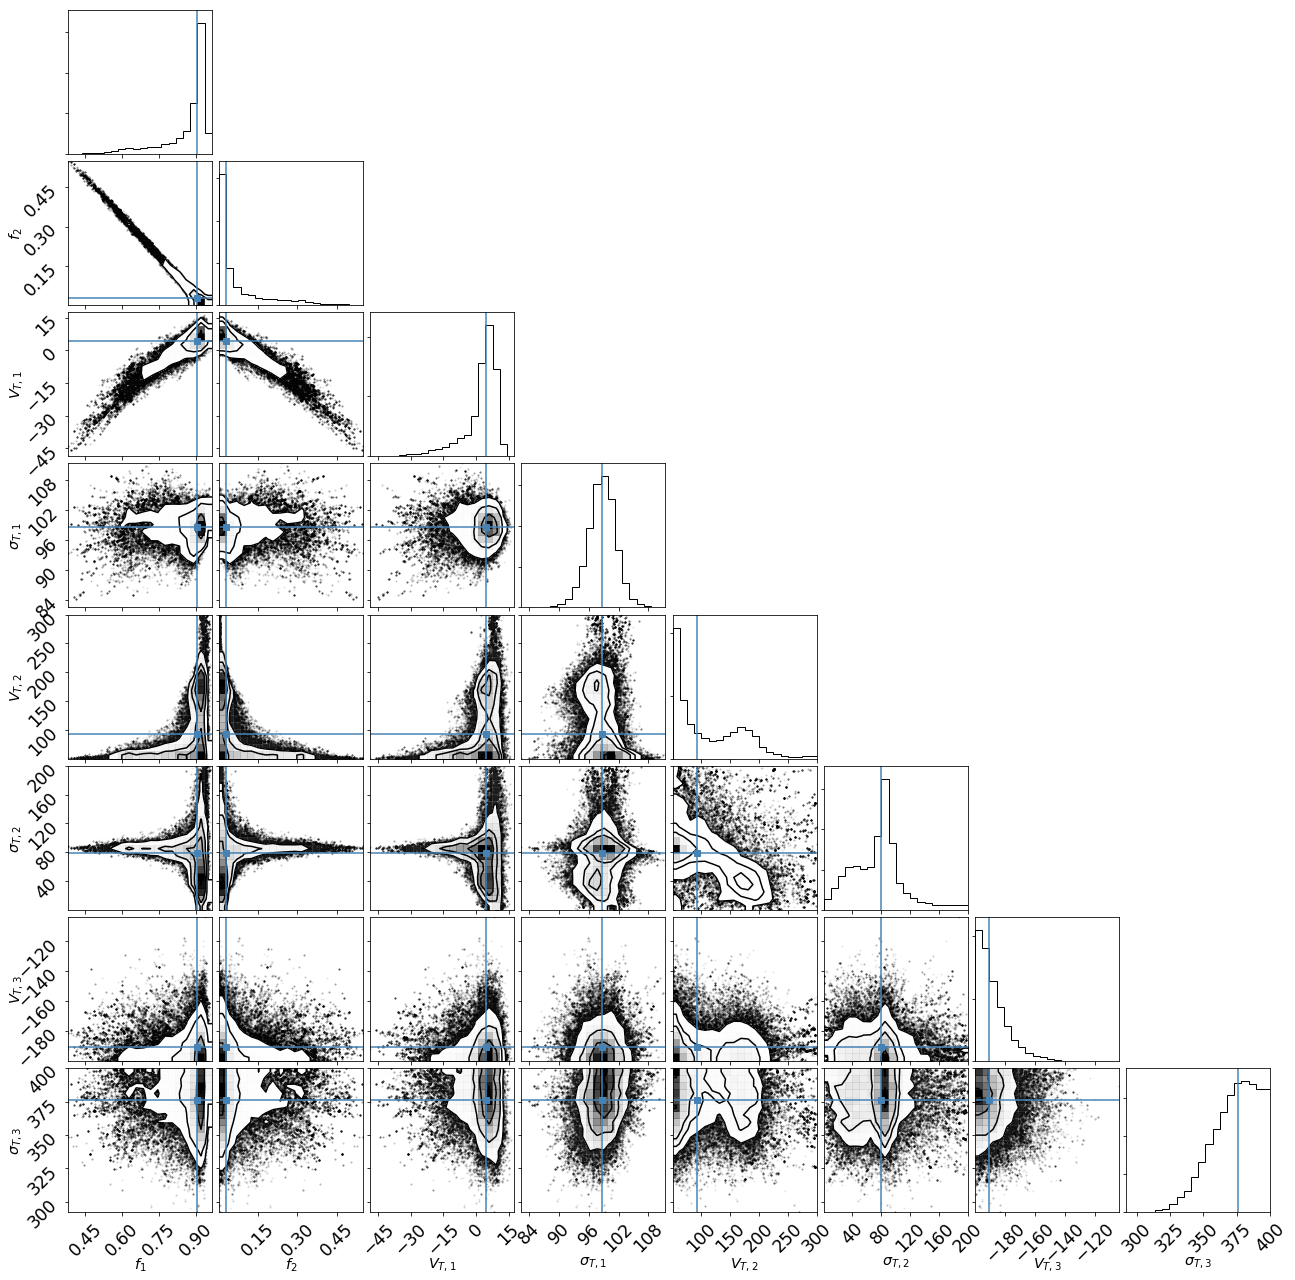

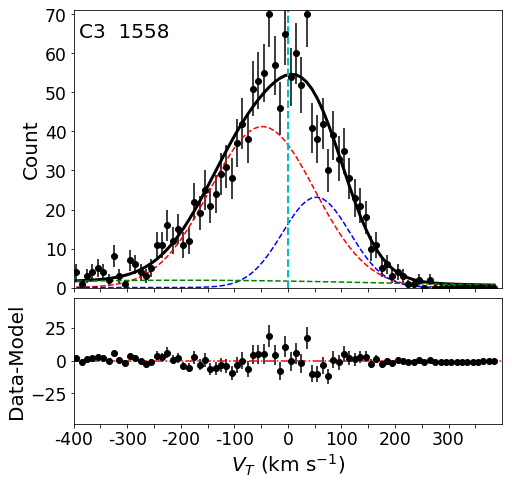

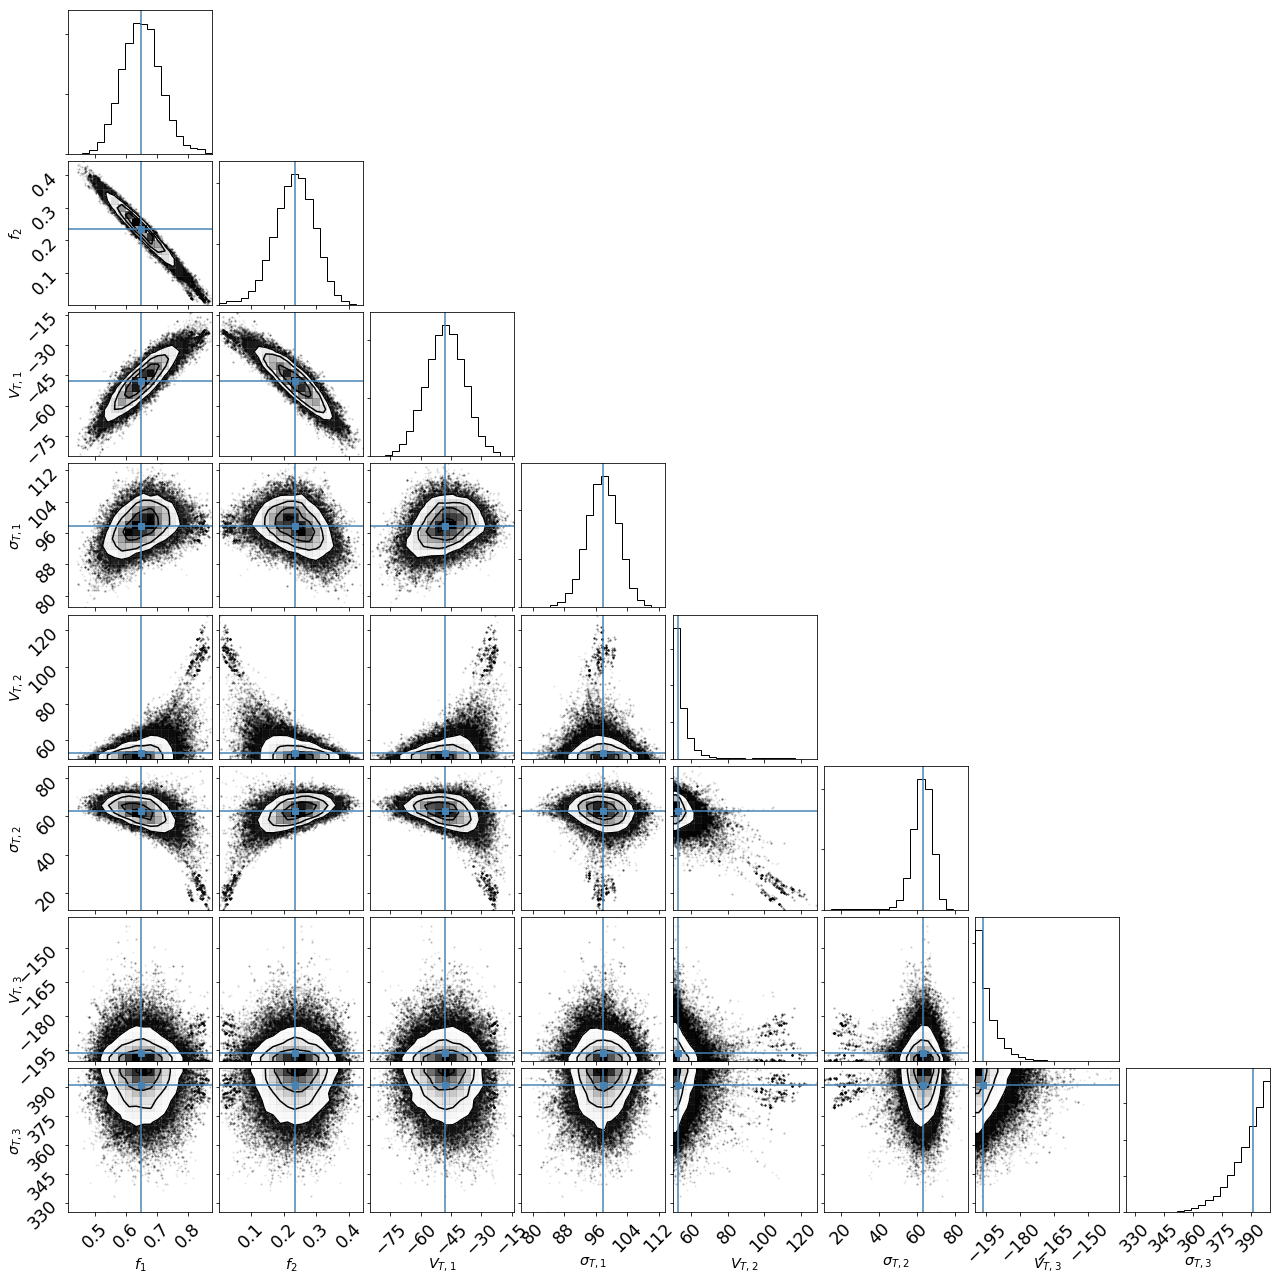

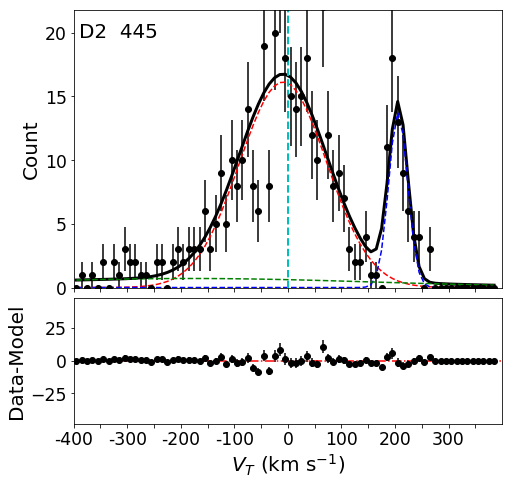

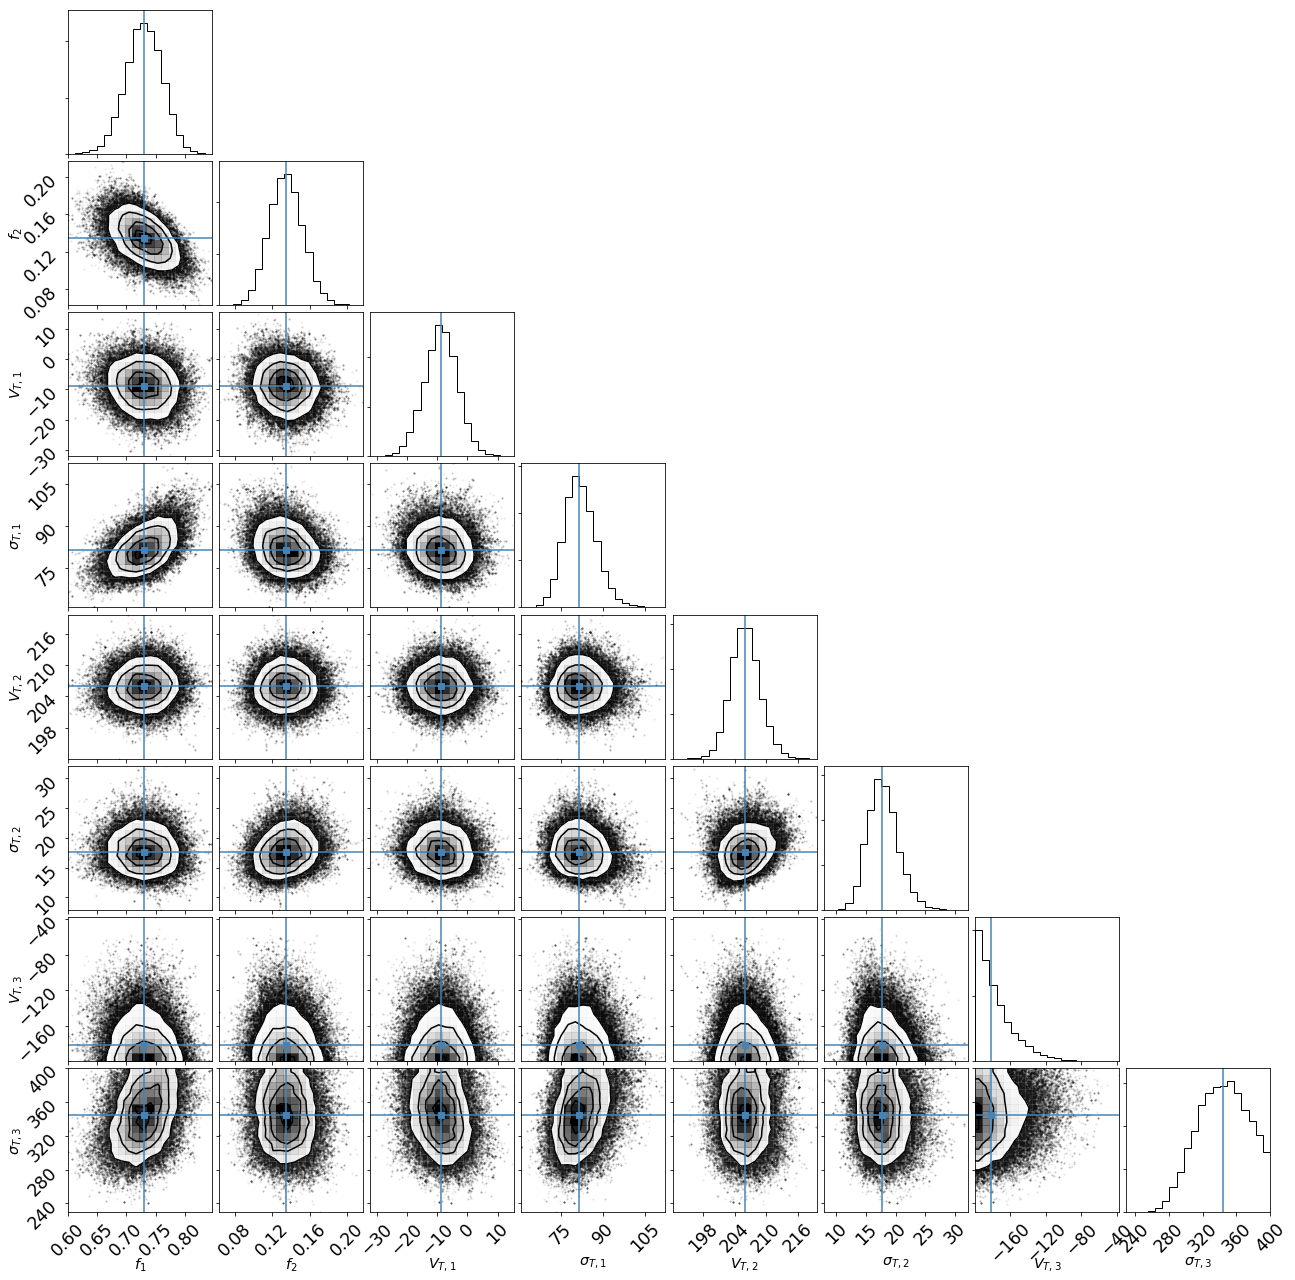

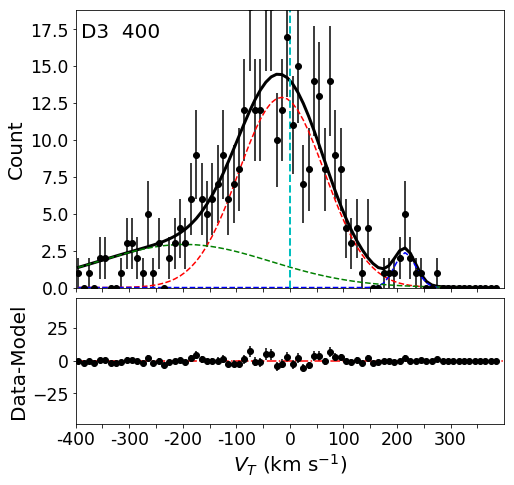

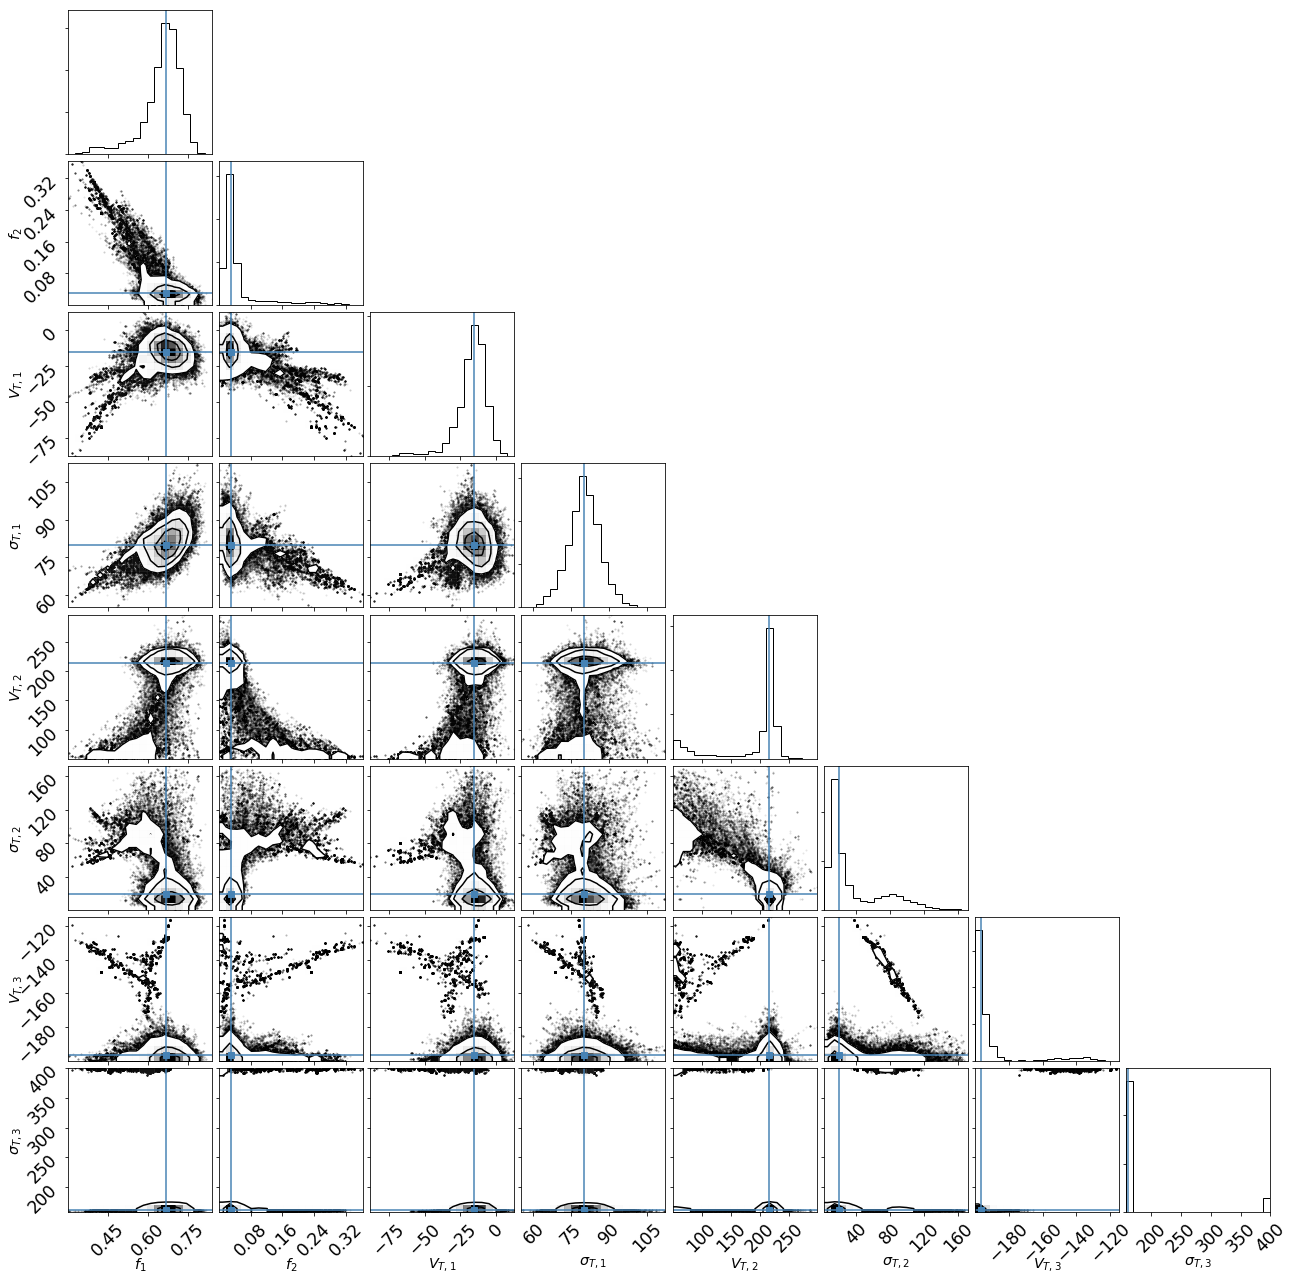

In [14]:
#  bin the space x np.linspace(0,20,5), y np.linspace(-5,5,3),z [-5,-1] [1,5]
ymin = np.array([-5])
ymax = np.array([5])
xmin = np.linspace(0,20,5)[:-1]
xmax = np.linspace(0,20,5)[1:]
zmin = np.array([-5,1,5])
zmax = np.array([-1,5,9])
nx, ny, nz = len(xmin), len(ymin), len(zmin)
bins_v = np.linspace(-400,400,81)
n_rcd = np.zeros((nx,ny,nz))
xs = ["A","B","C","D"]
zs = ["1","2","3"]

for ix in range(0,nx):
    for iy in range(0,ny):
        for iz in range(0,nz):
            ind_bs = (xyz_gc[:,0]>xmin[ix]) & (xyz_gc[:,0]<xmax[ix]) & \
                     (xyz_gc[:,1]>ymin[iy]) & (xyz_gc[:,1]<ymax[iy]) & \
                     (xyz_gc[:,2]>zmin[iz]) & (xyz_gc[:,2]<zmax[iz])
            n_rcd[ix,iy,iz] = len(xyz_gc[ind_bs,0])
            n_s = int(n_rcd[ix,iy,iz])
            sloc = xs[ix]+zs[iz]+"  {n_s}".format(**locals())
            print('=============================================')
            print(sloc)
            if n_rcd[ix,iy,iz]>300:
#                 sloc = "$N_{{}}$"
                Mpopt3,Mpcov3, samples3 = gauss2_model(vrvtvz[ind_bs,1], p0, 5000, lnprob_gauss3, nwalkers)
                ss = np.sqrt(np.diag(Mpcov3))
                draw_VT(vrvtvz[ind_bs,1],Mpopt3,"",sloc)
                fig = corner.corner(samples3,labels=["$f_1$","$f_2$","$V_{T,1}$","$\sigma_{T,1}$",\
                                                     "$V_{T,2}$","$\sigma_{T,2}$",\
                                                     "$V_{T,3}$","$\sigma_{T,3}$"],\
                                    truths=Mpopt3,fontsize=15)
                print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3[0],'f1e':ss[0],'f2':Mpopt3[1],'f2e':ss[1]})
                print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3[2],'v1e':ss[2],\
                                                                    's1':Mpopt3[3],'s1e':ss[3]})
                print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3[4],'v2e':ss[4],\
                                                                    's2':Mpopt3[5],'s2e':ss[5]})
                print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3[6],'v3e':ss[6],\
                                                                    's3':Mpopt3[7],'s3e':ss[7]})

                print("------------------------------------------")
#                 hyvr,hxvr = np.histogram(vrvtvz[ind_bs,0],bins=bins_v)
#                 hyvt,hxvt = np.histogram(vrvtvz[ind_bs,1],bins=bins_v)
#                 hyvz,hxvz = np.histogram(vrvtvz[ind_bs,2],bins=bins_v)
#                 plotvr = pth.ploth2D(hxvr[:-1],hyvr)
#                 plotvr.ploth_hist(xlabel="$V_R$")
                
    

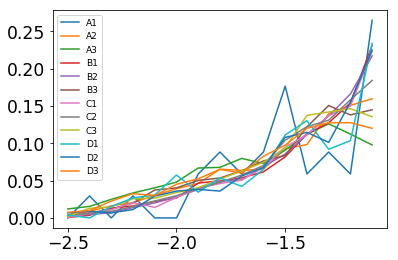

In [15]:
fig = plt.figure(figsize=(6,4))
bin_feh = np.linspace(-2.5,-1,16)
for ix in range(0,nx):
    for iy in range(0,ny):
        for iz in range(0,nz):
            sloc = xs[ix]+zs[iz]
            ind_bs = (xyz_gc[:,0]>xmin[ix]) & (xyz_gc[:,0]<xmax[ix]) & \
                     (xyz_gc[:,1]>ymin[iy]) & (xyz_gc[:,1]<ymax[iy]) & \
                     (xyz_gc[:,2]>zmin[iz]) & (xyz_gc[:,2]<zmax[iz])
            hyfeh,hxfeh = np.histogram(feh[ind_bs],bins=bin_feh)
            plt.plot(hxfeh[:-1],hyfeh/np.sum(hyfeh),label=sloc)
plt.legend(loc=2,fontsize=9)
plt.show()




NameError: name 'size' is not defined